<a href="https://colab.research.google.com/github/AtulBha/WS-SPARK---Coding-Challange/blob/main/Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install geopandas

In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [4]:
import findspark
findspark.init()

In [5]:
from pyspark.sql import SparkSession
from pyspark import SparkFiles

spark = SparkSession.builder.master('local').getOrCreate()

url = "https://raw.githubusercontent.com/EQWorks/ws-data-spark/master/data/DataSample.csv"
url2 = "https://raw.githubusercontent.com/EQWorks/ws-data-spark/master/data/POIList.csv"
spark.sparkContext.addFile(url)
spark.sparkContext.addFile(url2)


df = spark.read.csv(SparkFiles.get("DataSample.csv"), header=True, inferSchema= True)
poi = spark.read.csv(SparkFiles.get("POIList.csv"), header=True, inferSchema= True)
poi_df = poi.toPandas()

In [6]:
df.printSchema()

root
 |-- _ID: integer (nullable = true)
 |--  TimeSt: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Province: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)



In [7]:
display(df.columns)
df = df.withColumnRenamed(' TimeSt', 'TimeSt')
display(df.columns)

['_ID', ' TimeSt', 'Country', 'Province', 'City', 'Latitude', 'Longitude']

['_ID', 'TimeSt', 'Country', 'Province', 'City', 'Latitude', 'Longitude']

In [8]:
poi_df.rename(columns={' Latitude': 'Latitude'}, inplace=True)

# 1. Cleanup

In [9]:
df.persist()  # the dataset is relatively small

DataFrame[_ID: int, TimeSt: string, Country: string, Province: string, City: string, Latitude: double, Longitude: double]

In [10]:
display(df.count())
df = df.dropDuplicates(["Latitude", "Longitude", "TimeSt"])
df.count()

22025

19999

In [11]:
df.show(5)

+-------+--------------------+-------+--------+----------+--------+---------+
|    _ID|              TimeSt|Country|Province|      City|Latitude|Longitude|
+-------+--------------------+-------+--------+----------+--------+---------+
|4520345|2017-06-21 22:00:...|     CA|      ON|   Windsor| 42.2654| -83.0261|
|5156965|2017-06-21 22:44:...|     CA|      ON|    London| 42.9334| -81.2258|
|5278748|2017-06-21 16:54:...|     CA|      ON|    London|42.98761|-81.25129|
|4576469|2017-06-21 06:02:...|     CA|      ON|   Grimsby| 43.1976| -79.5756|
|5081522|2017-06-21 18:39:...|     CA|      ON|Burlington| 43.3889| -79.7682|
+-------+--------------------+-------+--------+----------+--------+---------+
only showing top 5 rows



In [12]:
poi_df.drop_duplicates(["Latitude", "Longitude"], inplace=True)

In [13]:
poi_df.loc[2:,['POIID']] = ['POI2', 'POI3']
poi_df.reset_index(inplace=True, drop=True)

# 2. Label

In [14]:
poi_df

,POIID,Latitude,Longitude
0,POI1,53.546167,-113.485734
1,POI2,45.521629,-73.566024
2,POI3,45.224830,-63.232729


It is important to note that Euclidean distance is calculated on a cartesian plane. Since we are dealing with geographic data we also need to consider elevation or adjust the Euclidean formula. However, in order to answer Q3. and plot the circle we use Euclidean distance (2D). A more in-depth topic to consider is spatial relation (https://en.wikipedia.org/wiki/Spatial_relation)

In [15]:
from pyspark.sql.functions import pandas_udf
from scipy.spatial import distance
from geopy.distance import distance as geopy_distance
import pandas as pd
import numpy as np



def label_geoClass(lat, long, distFunc):

  @pandas_udf("class string, minDist float")
  def label_udf(lat: pd.Series, long: pd.Series) -> pd.DataFrame:
    lat_long = np.column_stack((lat, long))
    #lat_long = pd.DataFrame({'Latitude' : lat, 'Longitude': long})

    distances = distance.cdist(lat_long,
                               poi_df[['Latitude', 'Longitude']].values,
                               distFunc)
    
    class_labels = poi_df.iloc[distances.argmin(axis=1), 0]
    min_distances = distances.min(axis=1)
      
    return pd.DataFrame({'class': class_labels, 'minDist': min_distances})
  
  return label_udf(lat, long)
  

distFunc = 'euclidean'  #lambda u, v: geopy_distance(u, v).km
df = df.withColumn("class_minDist",  label_geoClass('Latitude', 'Longitude', distFunc))

In [16]:
temp = df.toPandas()
temp['geoClass'] = temp.class_minDist.map(lambda x: x['class'])
temp['minDist'] = temp.class_minDist.map(lambda x: x['minDist'])

# 3. Analysis

In [17]:
from pyspark.sql import functions as F

summary = df.groupBy('class_minDist.class')\
            .agg(F.avg('class_minDist.minDist').alias('Avg Min Distance'),
                F.stddev('class_minDist.minDist').alias('STD'),
                F.count('*').alias('NumObs'),
                F.max('class_minDist.minDist').alias('Radius'))\
            .orderBy('Avg Min Distance')\
            .withColumnRenamed('class_minDist.class', 'geoClass')\
            .toPandas()

summary = summary.merge(poi_df, left_on='geoClass', right_on='POIID').drop('POIID', axis=1)

summary['Density'] = summary.NumObs / (np.pi*(summary.Radius**2))
summary

,geoClass,Avg Min Distance,STD,NumObs,Radius,Latitude,Longitude,Density
0,POI1,3.348183,3.85849,9698,24.851936,53.546167,-113.485734,4.998179
1,POI2,5.537951,2.85869,9817,20.155378,45.521629,-73.566024,7.692136
2,POI3,8.810411,28.67513,484,192.704987,45.224830,-63.232729,0.004149


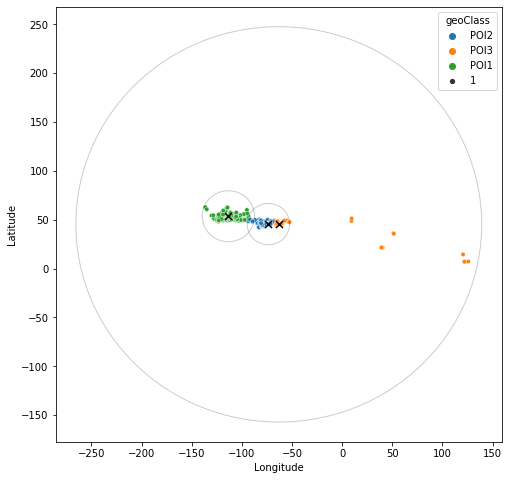

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.figure(figsize=(8,8))
ax = sns.scatterplot(data=temp, x="Longitude", y="Latitude", hue="geoClass",
                     size=1)

def encircle(x, y, r, center, ax=ax, **kw):
    
    p = np.column_stack([x,y])
    #mean = np.mean(p, axis=0)
    #d = p-mean
    #r = np.max(np.sqrt(d[:,0]**2+d[:,1]**2 ))
    #circ = plt.Circle(mean, radius=1.05*r,**kw)
    circ = plt.Circle(center, radius=1.05*r,**kw)
    ax.add_patch(circ)

for data in summary.itertuples():
  ax.scatter(data.Longitude,data.Latitude, s=50, marker='x', color='black')
  encircle(temp[temp.geoClass == data.geoClass].Longitude,
           temp[temp.geoClass == data.geoClass].Latitude,
           r=data.Radius,
           center=np.array([data.Longitude, data.Latitude]),
           ec="k", fc="none", alpha=0.2)

plt.gca().relim()
plt.gca().autoscale_view()
plt.show()

# 4a i). Outlier detection & Custom Scaling

#### Outlier detection

In [19]:
outliers = dict()
for poi in summary.itertuples():
  poi_mean, poi_std = poi._2, poi.STD
  cut_off = poi_std * 3
  lower, upper = poi_mean - cut_off, poi_mean + cut_off
  outliers[poi.geoClass] = temp.loc[(temp.geoClass == poi.geoClass) &
                                    ((temp.minDist < lower) | (temp.minDist > upper)),
                                    ['minDist']].index

In [20]:
'|'.join(poi + ':' + str(len(outliers)) if len(outliers) else poi + ':' + str(0)
         for poi,outliers in outliers.items())  # outliers present in POI

'POI1:281|POI2:213|POI3:20'

#### Scaled (-10,10) with Robust Scaling

In [21]:
# Robust scaling is insensitive to outliers
# Ref: https://machinelearningmastery.com/robust-scaler-transforms-for-machine-learning/

def robust_custom_scale(X):
  
  X_max = X.quantile(q=0.75)
  X_min = X.quantile(q=0.25)
  X_std = (X - X.median()) / (X_max - X_min)

  X_std_max = X_std.max()
  X_std_min = X_std.min()
  X_std2 = (X_std - X_std_min) / (X_std_max - X_std_min)

  scale_max = 10
  scale_min = -10
  X_scaled = X_std2 * (scale_max - scale_min) + scale_min
  return X_scaled

temp['minDist_Scaled'] = temp.groupby('geoClass').minDist.apply(robust_custom_scale)
temp.minDist_Scaled.describe()  # scale -10, 10

count    19999.000000
mean        -5.978734
std          3.316169
min        -10.000000
25%         -8.148431
50%         -6.907490
75%         -3.835561
max         10.000000
Name: minDist_Scaled, dtype: float64

#### Visualize POI variance and distribution

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

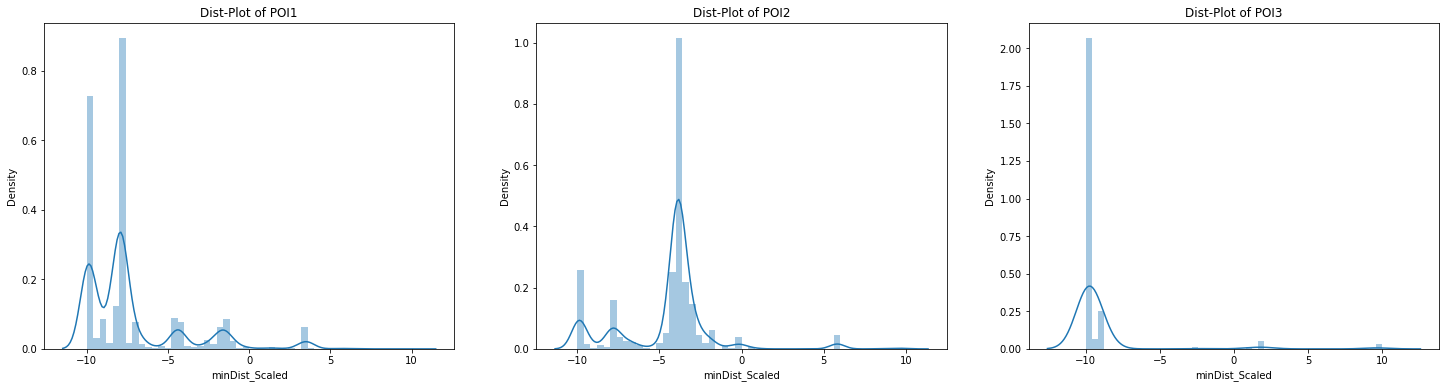

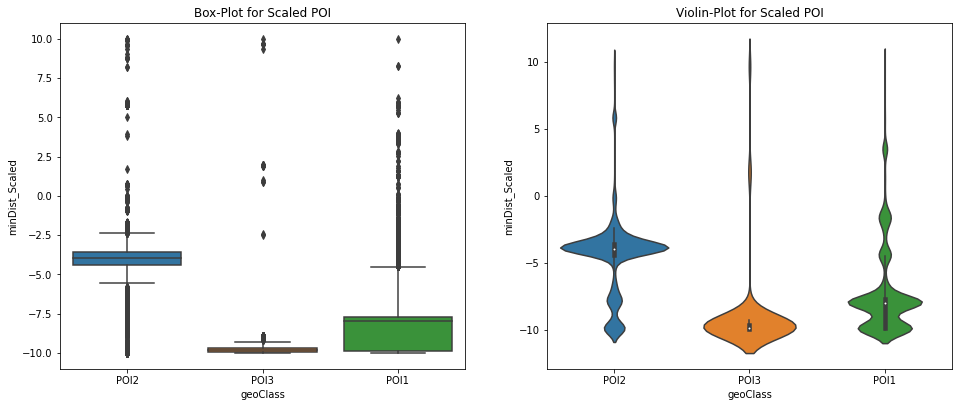

In [22]:
plt.figure(figsize=(25,6))
for i, row in enumerate(summary.itertuples(), 1):
  plt.subplot(1,summary.shape[0],i)
  sns.distplot(temp.loc[temp.geoClass == row.geoClass,'minDist_Scaled'])
  plt.title("Dist-Plot of {}".format(row.geoClass))
plt.show()

plt.figure(figsize=(16,14))
plt.subplot(2,2,1)
sns.boxplot(x='geoClass', y='minDist_Scaled', data=temp)
plt.title("Box-Plot for Scaled POI")

plt.subplot(2,2,2)
sns.violinplot(x='geoClass', y='minDist_Scaled', data=temp)
plt.title("Violin-Plot for Scaled POI")
plt.show()

# 4a ii). Insights from Data

In [23]:
temp['TimeSt'] = pd.to_datetime(temp.TimeSt)

((5, 811), (1, 919))

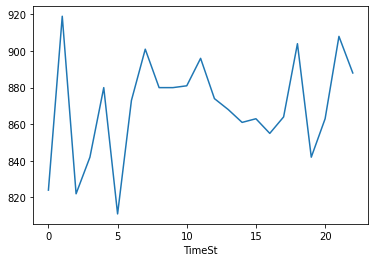

In [24]:
cnts = temp.groupby(temp.TimeSt.dt.hour)['_ID'].count()
cnts.plot()
min_idx, max_idx = cnts.idxmin(), cnts.idxmax()
(min_idx, cnts[min_idx]), (max_idx, cnts[max_idx])

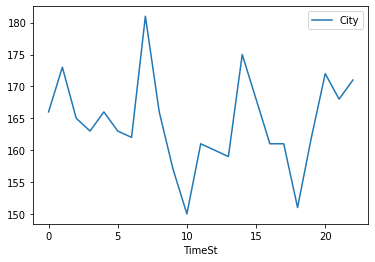

In [25]:
unique_city_activity = temp.groupby(temp.TimeSt.dt.hour).agg({'City': 'nunique'})
unique_city_activity.plot()
# 7-7:59 Highest Activity, 10-10:59 Lowest Activity from unique cities
# However, it generally follows the same trend as above

In [26]:
city_activity_freq = temp.City.value_counts()
major_activity_cities = city_activity_freq[city_activity_freq > (unique_city_activity.mean().values[0])]
(major_activity_cities.shape[0] / city_activity_freq.shape[0]) * 100
# Most of the activity comes from about top 3.35 % of cities

3.353658536585366

In [27]:
city_activity_freq[ city_activity_freq == city_activity_freq.quantile(q=0.01)].shape[0]
# Bottom Cities

243

# 4b) Pipeline Dependency

## Solution

In [28]:
from collections import deque

def resolveDAG(starting_tasks, goal_task, graph):
  output = []
  completed_tasks = set()
  queue = deque()
  queue.append(goal_task)

  for task in starting_tasks:  # Dependencies for starting tasks are completed
    completed_depends = graph[task]
    if completed_depends:      # iff there are dependencies
      for cd in completed_depends:
        completed_tasks.add(cd)

  while queue:
    prevTask = queue.popleft()
    if prevTask not in completed_tasks: # only add to DAG if not completed
      output.insert(0, str(prevTask))
      completed_tasks.add(prevTask)
    if prevTask not in starting_tasks:  # only resolve dependency iff not starting
      dependencies = graph[prevTask]
      queue.extend(dependencies)

  print('->'.join(output))

Test Cases

In [29]:
from collections import defaultdict

relations = '''A->C
B->C
C->E
E->F'''

graph = defaultdict(list)
for pair in relations.split('\n'):
  v,k = pair.split('->')
  graph[k].append(v)

graph

#TC 1
starting_tasks = {'A'}
goal_task = 'F'
resolveDAG(starting_tasks, goal_task, graph)

#TC 2
starting_tasks = {'A', 'C'}
resolveDAG(starting_tasks, goal_task, graph)

B->A->C->E->F
C->E->F


## Final Submission

In [30]:
!wget -q https://gist.githubusercontent.com/woozyking/f1d50e1fe1b3bf52e3748bc280cf941f/raw/2d582e0b6d2a55bd50289b4fb2889f321693e288/relations.txt

relations = pd.read_csv('relations.txt', header=None, sep=r'->', names=['Dependency', 'Task'], engine='python')
relations.head(2)

,Dependency,Task
0,97,102
1,75,31


In [31]:
!wget -q https://gist.githubusercontent.com/woozyking/f1d50e1fe1b3bf52e3748bc280cf941f/raw/2d582e0b6d2a55bd50289b4fb2889f321693e288/task_ids.txt

graph = dict()
with open('task_ids.txt', 'r') as f:
  for task_id in f.readline().split(','):
    graph[int(task_id)] = []

for row in relations.itertuples():
  graph[row.Task].append(row.Dependency)
graph

{16: [],
 20: [100, 21, 73],
 21: [],
 31: [75, 102, 55],
 36: [102],
 37: [75, 102, 16, 55],
 39: [],
 41: [],
 55: [62, 56],
 56: [94],
 62: [],
 73: [39, 41],
 75: [56],
 94: [20],
 97: [112, 20],
 100: [39],
 102: [97, 56, 94],
 112: [41]}

In [32]:
starting_tasks = {73}
goal_task = 36
resolveDAG(starting_tasks, goal_task, graph)

73->21->100->20->112->94->56->97->102->36
